In [46]:
%matplotlib inline
import numpy as np
import sklearn.datasets as data
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sb; sb.set_style( 'darkgrid' ) # use whitegrid if prefer a white background
import pandas as pd

from numpy.random import SeedSequence, default_rng
rng = default_rng( SeedSequence().entropy )

import warnings
warnings.filterwarnings("ignore")

#matplotlib.rcParams.update( { 'font.size': 18 } ) # Use this to setup your preferred font size for plotting

In [47]:
# Data
X, y = data.load_breast_cancer( return_X_y = True, as_frame = False )

In [59]:
help( data.load_breast_cancer )

Help on function load_breast_cancer in module sklearn.datasets._base:

load_breast_cancer(*, return_X_y=False, as_frame=False)
    Load and return the breast cancer wisconsin dataset (classification).
    
    The breast cancer dataset is a classic and very easy binary classification
    dataset.
    
    =================   ==============
    Classes                          2
    Samples per class    212(M),357(B)
    Samples total                  569
    Dimensionality                  30
    Features            real, positive
    =================   ==============
    
    The copy of UCI ML Breast Cancer Wisconsin (Diagnostic) dataset is
    downloaded from:
    https://goo.gl/U2Uwz2
    
    Read more in the :ref:`User Guide <breast_cancer_dataset>`.
    
    Parameters
    ----------
    return_X_y : bool, default=False
        If True, returns ``(data, target)`` instead of a Bunch object.
        See below for more information about the `data` and `target` object.
    
       

#### 1- Compare Gradient Boosting, SVM and Multi-layer Perceptrons using Cross validation with Receiver Characteristic Operator curves, and confusion matrix on the provided dataset above. That is,

+ Examine how regularization affects the training and cross-validation curves
+ Examine how different K-fold evaluations affects model fitting using the ROC curves
+ Select the best regulairzation parameter and then confusion matrices of the models 

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Learning curves
from sklearn.model_selection import validation_curve

# Cross-validation and ROC curves
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

In [49]:
def plot_k_cv_roc( model, Kfolds, X, y, model_name ):
    '''
    Plots the ROC curves of each K-fold.
    model <- used estimator
    Kfolds <- Number of K-folds
    X <- feature data
    y <- label data
    model_name <- string containing model name for plot title
    '''
    K  = Kfolds
    cv = StratifiedKFold( n_splits = K )

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots( figsize = ( 10, 8 ))
    for i, (train, test) in enumerate(cv.split(X, y)):
        model.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(model, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="{0} Receiver operating characteristic example".format( model_name ))
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")

##### SVM: Using the Radial basis function $\text{ exp}(-\gamma||x_i - x_j||^2)$,  vary the $\gamma$ parameter which scales the size of the kernel. Also experiment with different regularization C terms.

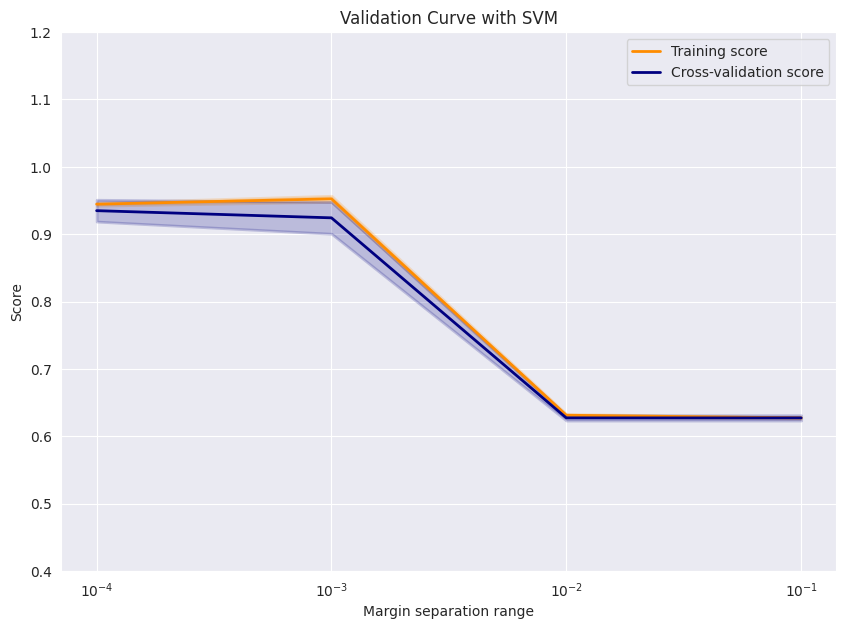

In [60]:
svc = SVC( C = 0.5, kernel = 'rbf' )

param_range = np.logspace(-4, -1, 4)

train_scores, test_scores = validation_curve(
    svc, X, y, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=4)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure( figsize = ( 10, 7 ) )
plt.title("Validation Curve with SVM")
plt.xlabel(r"Margin separation range")
plt.ylabel("Score")
plt.ylim(0.4, 1.2)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best");

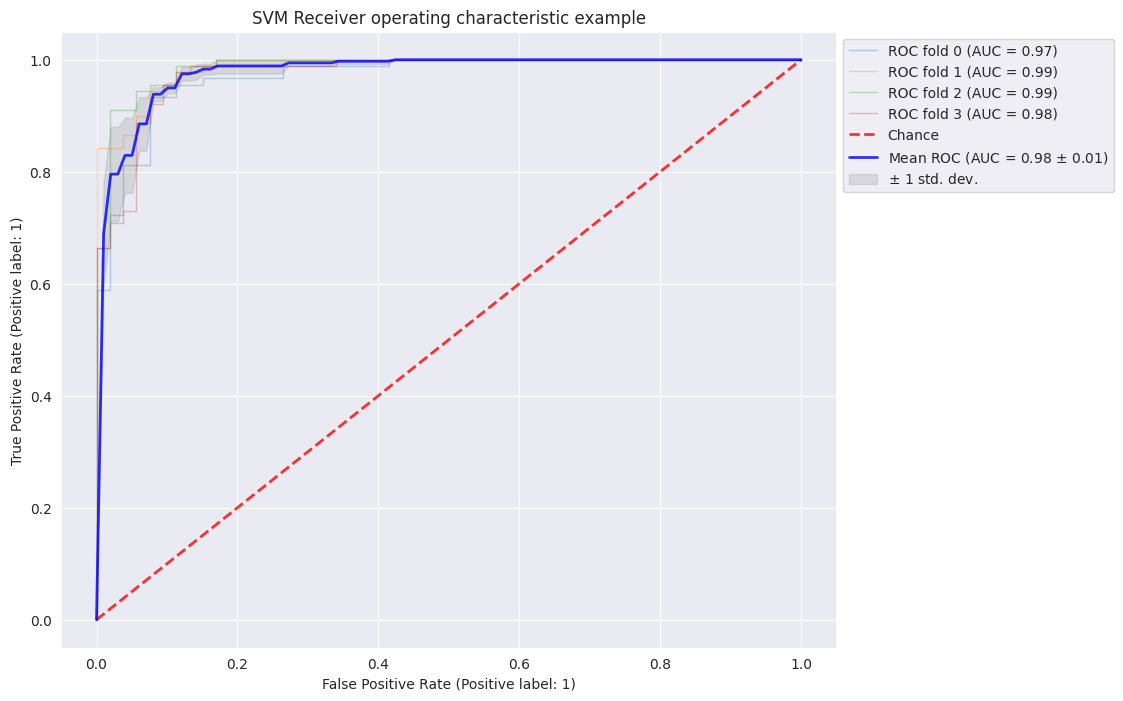

In [17]:
plot_k_cv_roc( svc, 4, X, y, 'SVM' )

###### MLP

/home/bilbrait/Projects/Courses/FundamentalsML/2023/fundamentals-machine-learning-main/fml2023/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bilbrait/Projects/Courses/FundamentalsML/2023/fundamentals-machine-learning-main/fml2023/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bilbrait/Projects/Courses/FundamentalsML/2023/fundamentals-machine-learning-main/fml2023/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bilbrait/Projects/Courses/FundamentalsML/2023/fundamentals

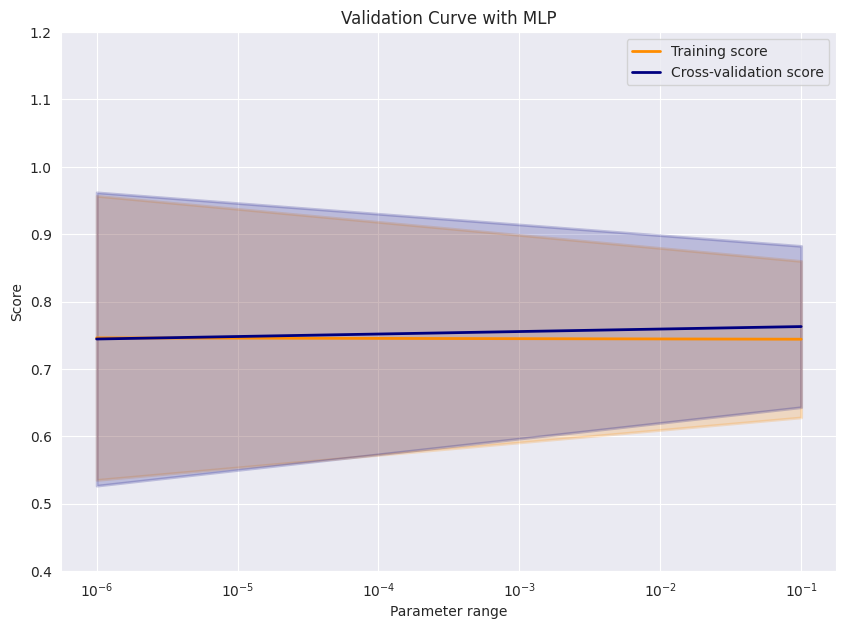

In [19]:
mlp = MLPClassifier( hidden_layer_sizes = (3, 3) )

param_range = np.logspace(-6, -1, 2)

train_scores, test_scores = validation_curve(
    mlp, X, y, param_name="alpha", param_range=param_range,
    scoring="accuracy", n_jobs=4)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure( figsize = ( 10, 7 ) )
plt.title("Validation Curve with MLP")
plt.xlabel(r"Parameter range")
plt.ylabel("Score")
plt.ylim(0.4, 1.2)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best");

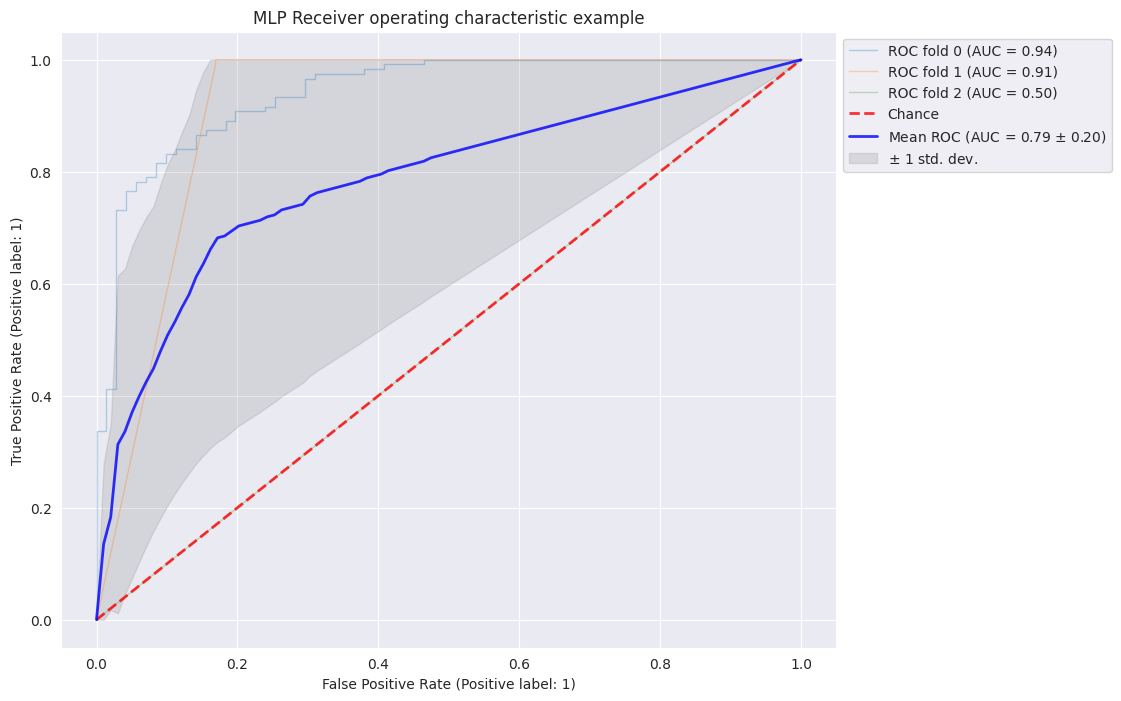

In [21]:
plot_k_cv_roc( mlp, 3, X, y, 'MLP' )

###### Gradient boosting

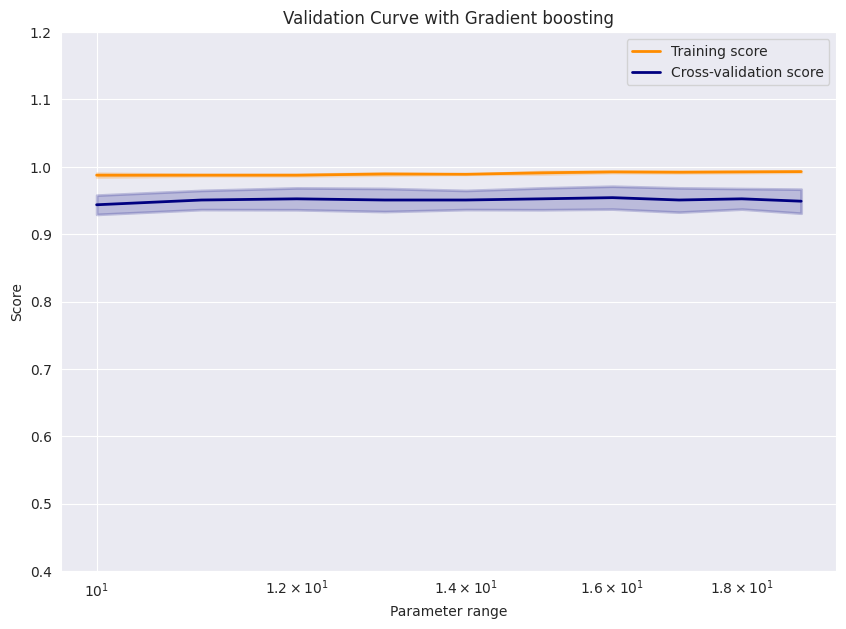

In [22]:
gb = GradientBoostingClassifier()

param_range = np.arange( 10, 20 )

train_scores, test_scores = validation_curve(
    gb, X, y, param_name="n_estimators", param_range=param_range,
    scoring="accuracy", n_jobs=4)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure( figsize = ( 10, 7 ) )
plt.title("Validation Curve with Gradient boosting")
plt.xlabel(r"Parameter range")
plt.ylabel("Score")
plt.ylim(0.4, 1.2)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best");

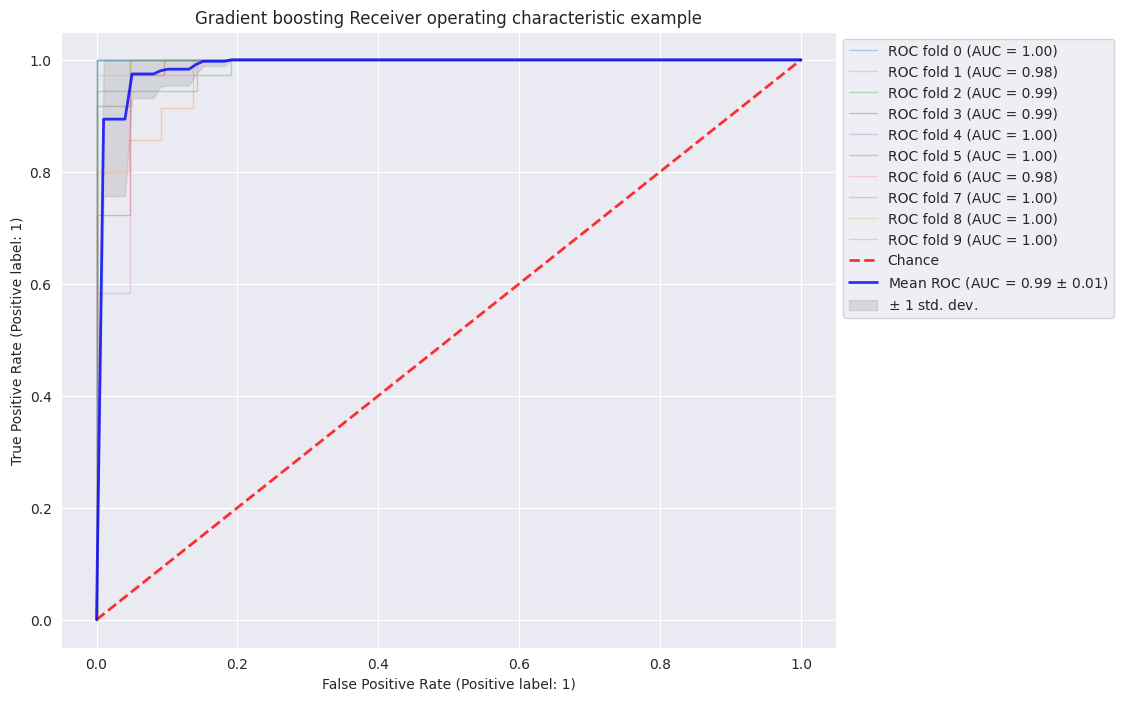

In [23]:
plot_k_cv_roc( gb, 10, X, y, 'Gradient boosting' )

#### Confusion matrix

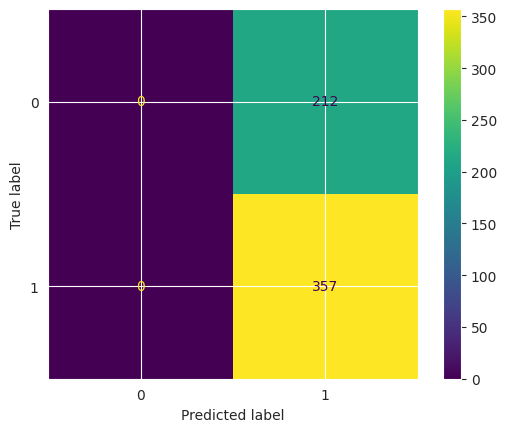

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix( y, mlp.predict( X ) )

cm_display = ConfusionMatrixDisplay(cm).plot()

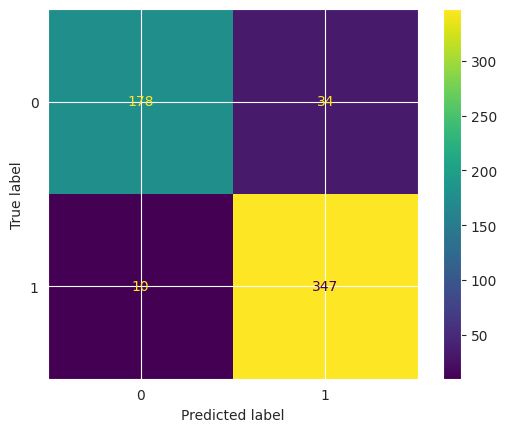

In [25]:
cm = confusion_matrix( y, svc.predict( X ) )

cm_display = ConfusionMatrixDisplay(cm).plot()

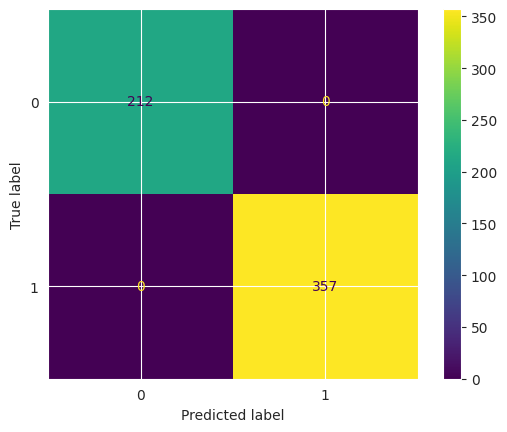

In [26]:
cm = confusion_matrix( y, gb.predict( X ) )

cm_display = ConfusionMatrixDisplay(cm).plot()

#### 2- Use Grid search for searching hyperparamters for the Multi-layered Perceptron. Fix some other hyperparamters by guessing but use Grid search to select the best solver, activation function, and number of hidden layers
+ Bonus: Do the same with SVM and Gradient boosting if you have time

In [27]:
X, y = data.load_digits( return_X_y = True )

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# You may choose a different test_size
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.5, random_state = rng.integers( 432 ) )

tuned_parameters = [{'solver': ['sgd', 'adam', 'lbfgs'], 
                     'activation': ['relu', 'logistic'], 
                     'hidden_layer_sizes': [ (10, ), ( 15, 15 ), (18, 10 )]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        MLPClassifier( max_iter = 5), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'activation': 'relu', 'hidden_layer_sizes': (15, 15), 'solver': 'lbfgs'}

Grid scores on development set:

0.176 (+/-0.133) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'solver': 'sgd'}
0.102 (+/-0.046) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'solver': 'adam'}
0.135 (+/-0.108) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'solver': 'lbfgs'}
0.183 (+/-0.133) for {'activation': 'relu', 'hidden_layer_sizes': (15, 15), 'solver': 'sgd'}
0.090 (+/-0.086) for {'activation': 'relu', 'hidden_layer_sizes': (15, 15), 'solver': 'adam'}
0.235 (+/-0.163) for {'activation': 'relu', 'hidden_layer_sizes': (15, 15), 'solver': 'lbfgs'}
0.120 (+/-0.201) for {'activation': 'relu', 'hidden_layer_sizes': (18, 10), 'solver': 'sgd'}
0.089 (+/-0.074) for {'activation': 'relu', 'hidden_layer_sizes': (18, 10), 'solver': 'adam'}
0.202 (+/-0.125) for {'activation': 'relu', 'hidden_layer_size

#### 3- Use MLP, SVM or Gradient boosting to do a recursive feature selection on the breast cancer dataset.
+ Bonus: If time, use the approach in Task 2, then move perform a recursive feature elimination with the hyperparameter optimized model. Is this a valid approach?

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV # use help to check RFECV

X, y = data.load_breast_cancer( return_X_y = True, as_frame = True )
print( X.shape )
X.head()

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Optimal number of features : 14


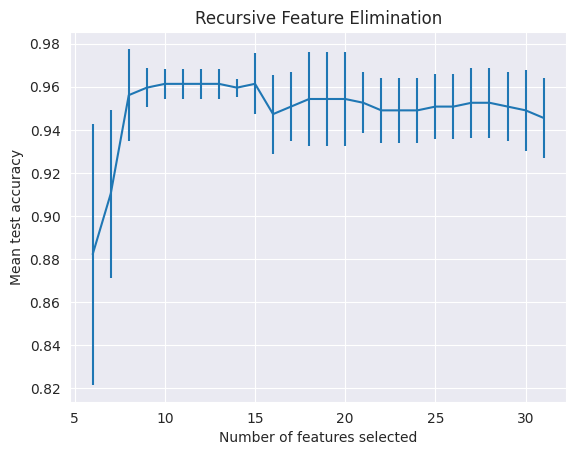

In [61]:
svc                 = SVC( kernel = 'linear')
Kfold               = 5
select_min_features = 6

rfecv = RFECV(estimator=svc, step = 1, 
              cv = StratifiedKFold( Kfold ),
              scoring='accuracy',
              min_features_to_select = 5 )
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(select_min_features, n_scores + select_min_features),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show();

#### 4- This an advance approach to model selection based on Bayesian Analysis. If you feel bored, then proceed to do this. Use whatever model you wish. This solution example is done using a MLP model.

#### Use the approach in Task 2 to hyperparameter optimize a selected model. Use either the same set of candidate parameters or make up more.

+ To understan the Bayes Analysis -based comparison of models, read on Region of Practical Equivalence https://doingbayesiandataanalysis.blogspot.com/2013/08/how-much-of-bayesian-posterior.html 

In [35]:
from sklearn.model_selection import RepeatedStratifiedKFold

# recommend using a small number of candidates to make sense of some plots
tuned_parameters = [{'solver': ['sgd', 'adam', 'lbfgs'], 
                     'activation': ['relu', 'logistic'], 
                     'hidden_layer_sizes': [10, 15, 18]}]

cv = RepeatedStratifiedKFold(
    n_splits=2, n_repeats=2, random_state=rng.integers( 5324 )
)

mlp = MLPClassifier( max_iter = 5)

search = GridSearchCV( estimator = mlp, param_grid=tuned_parameters, scoring='roc_auc', cv=cv )
search.fit(X, y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=2, random_state=3560),
             estimator=MLPClassifier(max_iter=5),
             param_grid=[{'activation': ['relu', 'logistic'],
                          'hidden_layer_sizes': [10, 15, 18],
                          'solver': ['sgd', 'adam', 'lbfgs']}],
             scoring='roc_auc')

In [36]:
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (
    results_df
    .set_index(results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
logistic_18_sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",1,0.899102,0.043231
relu_15_lbfgs,"{'activation': 'relu', 'hidden_layer_sizes': 1...",2,0.790638,0.177358
logistic_15_lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",3,0.785283,0.163720
logistic_15_adam,"{'activation': 'logistic', 'hidden_layer_sizes...",4,0.703602,0.328432
relu_10_lbfgs,"{'activation': 'relu', 'hidden_layer_sizes': 1...",5,0.696286,0.199952
logistic_15_sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",6,0.678132,0.237336
logistic_18_adam,"{'activation': 'logistic', 'hidden_layer_sizes...",7,0.643989,0.270726
logistic_10_sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",8,0.633750,0.349226
relu_15_adam,"{'activation': 'relu', 'hidden_layer_sizes': 1...",9,0.607357,0.185949


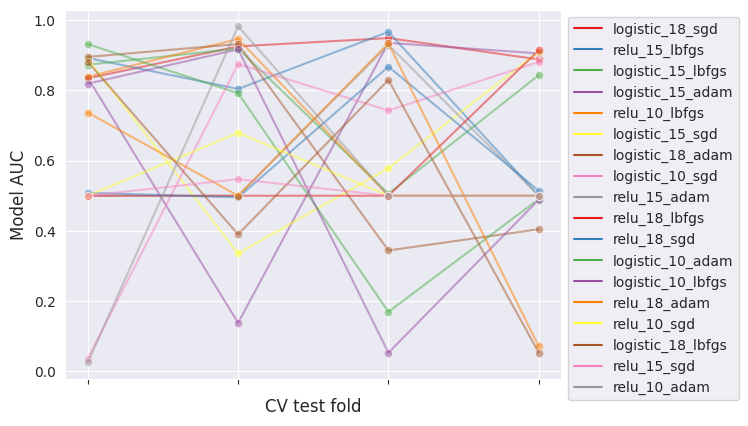

Correlation of models:
 kernel             logistic_18_sgd  relu_15_lbfgs  logistic_15_lbfgs   
kernel                                                                 
logistic_18_sgd           1.000000       0.186328          -0.591193  \
relu_15_lbfgs             0.186328       1.000000          -0.476459   
logistic_15_lbfgs        -0.591193      -0.476459           1.000000   
logistic_15_adam         -0.246956      -0.051721          -0.544856   
relu_10_lbfgs            -0.297512       0.284651           0.683172   
logistic_15_sgd          -0.733706      -0.404105           0.089975   
logistic_18_adam         -0.448960       0.241032           0.735952   
logistic_10_sgd           0.789864      -0.444188          -0.158456   
relu_15_adam              0.664060       0.571902          -0.986336   
relu_18_lbfgs            -0.147401      -0.946105           0.205084   
relu_18_sgd               0.644064       0.550751          -0.992552   
logistic_10_adam         -0.723107      

In [38]:
# create df of model scores ordered by perfomance
model_scores = results_df.filter(regex=r'split\d*_test_score')

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sb.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False, palette='Set1', marker='o', alpha=.5, ax=ax
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
#plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")

In [39]:
from scipy.stats import t


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples, 1)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : int
        Variance-corrected standard deviation of the set of differences.
    """
    n = n_train + n_test
    corrected_var = (
        np.var(differences, ddof=1) * ((1 / n) + (n_test / n_train))
    )
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples, 1)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

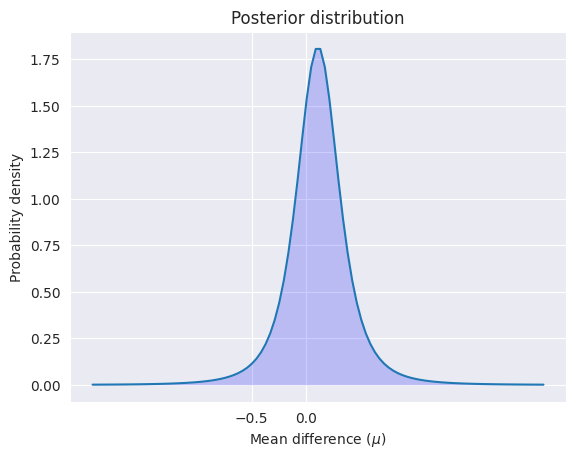

In [40]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores

n       = differences.shape[0]  # number of test sets
df      = n - 1
n_train = len(list(cv.split(X, y))[0][0])
n_test  = len(list(cv.split(X, y))[0][1])

# intitialize random variable
t_post = t(
    df, loc=np.mean(differences),
    scale=corrected_std(differences, n_train, n_test)
)

x = np.linspace(t_post.ppf(0.001), t_post.ppf(0.999), 100)

plt.plot(x, t_post.pdf(x))
plt.xticks(np.arange(-0.5, 0.01, 0.5))
plt.fill_between(x, t_post.pdf(x), 0, facecolor='blue', alpha=.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution")
plt.show()

In [41]:
better_prob = 1 - t_post.cdf(0)

print(f"Probability of {model_scores.index[0]} being more accurate than "
      f"{model_scores.index[1]}: {better_prob:.3f}")
print(f"Probability of {model_scores.index[1]} being more accurate than "
      f"{model_scores.index[0]}: {1 - better_prob:.3f}")

Probability of logistic_18_sgd being more accurate than relu_15_lbfgs: 0.686
Probability of relu_15_lbfgs being more accurate than logistic_18_sgd: 0.314


In [42]:
rope_interval = [-0.01, 0.01]
rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

print(f"Probability of {model_scores.index[0]} and {model_scores.index[1]} "
      f"being practically equivalent: {rope_prob:.3f}")

Probability of logistic_18_sgd and relu_15_lbfgs being practically equivalent: 0.030


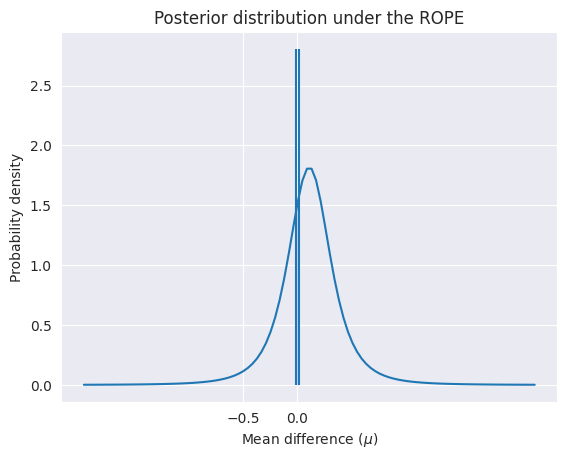

In [43]:
x_rope = np.linspace(rope_interval[0], rope_interval[1], 100)

plt.plot(x, t_post.pdf(x))
plt.xticks(np.arange(-0.5, 0.01, 0.5))
plt.vlines([-0.01, 0.01], ymin=0, ymax=(np.max(t_post.pdf(x)) + 1))
plt.fill_between(x_rope, t_post.pdf(x_rope), 0, facecolor='blue', alpha=.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution under the ROPE")
plt.show()

In [44]:
cred_intervals = []
intervals = [0.5, 0.75, 0.95]

for interval in intervals:
    cred_interval = list(t_post.interval(interval))
    cred_intervals.append([interval, cred_interval[0], cred_interval[1]])

cred_int_df = pd.DataFrame(
    cred_intervals,
    columns=['interval', 'lower value', 'upper value']
).set_index('interval')
cred_int_df

,lower value,upper value
interval,,
0.50,-0.046109,0.263036
0.75,-0.179026,0.395954
0.95,-0.534657,0.751585


In [45]:
from itertools import combinations
from math import factorial

n_comparisons = (
    factorial(len(model_scores))
    / (factorial(2) * factorial(len(model_scores) - 2))
)

pairwise_bayesian = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_post = t(
        df, loc=np.mean(differences),
        scale=corrected_std(differences, n_train, n_test)
    )
    worse_prob = t_post.cdf(rope_interval[0])
    better_prob = 1 - t_post.cdf(rope_interval[1])
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    pairwise_bayesian.append([model_scores.index[model_i], model_scores.index[model_k], worse_prob, better_prob, rope_prob])

pairwise_bayesian_df = (pd.DataFrame(
    pairwise_bayesian,
    columns=['model_1', 'model_2','worse_prob', 'better_prob', 'rope_prob']
).round(3))

pairwise_bayesian_df

,model_1,model_2,worse_prob,better_prob,rope_prob
0,logistic_18_sgd,relu_15_lbfgs,0.299,0.670,0.030
1,logistic_18_sgd,logistic_15_lbfgs,0.309,0.663,0.028
2,logistic_18_sgd,logistic_15_adam,0.320,0.664,0.016
3,logistic_18_sgd,relu_10_lbfgs,0.229,0.751,0.020
4,logistic_18_sgd,logistic_15_sgd,0.257,0.726,0.017
...,...,...,...,...,...
148,relu_10_sgd,relu_15_sgd,0.281,0.624,0.094
149,relu_10_sgd,relu_10_adam,0.440,0.538,0.023
150,logistic_18_lbfgs,relu_15_sgd,0.466,0.515,0.018
151,logistic_18_lbfgs,relu_10_adam,0.475,0.514,0.011
